In [1]:
import pandas as pd
import numpy as np
import stumpy
import sklearn
import lightgbm
import xgboost
import skforecast
import statsmodels
import matplotlib.pyplot as plt

In [2]:
prediction_input = pd.read_parquet("data/prediction_input.parquet")
input_dataset_2 = pd.read_parquet("data/input_dataset-2.parquet")

ConversionError: Failed to convert value(s) to axis units: array(['operation', 'operation', 'operation', ..., 'operation',
       'operation', 'operation'], dtype=object)

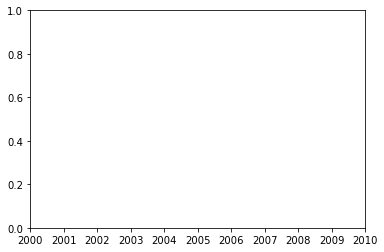

In [3]:
plt.plot(prediction_input)
plt.show()


In [5]:
df = pd.DataFrame(input_dataset_2)
df_prediction = pd.DataFrame(prediction_input)

<AxesSubplot:xlabel='timepoints'>

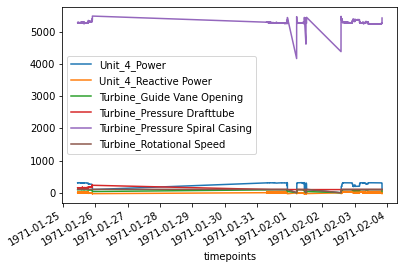

In [7]:
df_prediction.plot()

In [8]:
print(df.columns)
df.shape
df.index
df_prediction.head()

Index(['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode', 'Bolt_1_Steel tmp',
       'Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Bolt_1_Torsion', 'Bolt_2_Torsion',
       'Bolt_3_Torsion', 'Bolt_4_Torsion', 'Bolt_5_Torsion', 'Bolt_6_Torsion',
       'lower_bearing_vib_vrt', 'turbine_bearing_vib_vrt'],
      dtype='object')


,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,
1971-01-25 11:06:49,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,operation
1971-01-25 11:06:50,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,operation
1971-01-25 11:06:51,308.928605,7.037091,94.449024,158.246614,5279.985105,108.057454,operation
1971-01-25 11:06:52,308.958974,7.822213,94.452361,158.290399,5280.039368,108.057448,operation
1971-01-25 11:06:53,308.989343,8.607335,94.455698,158.302931,5280.058748,108.057442,operation


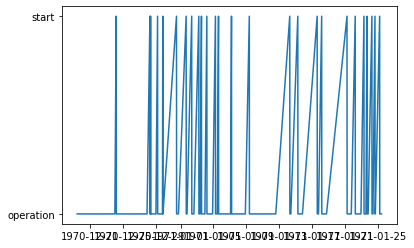

In [22]:
figure, ax1 = plt.subplots()
ax1.plot(df.iloc[:, 6])

In [6]:
def add_seconds_operational(dataframe):
    # Find index of "start" modes in the timeseries
    start_ts = dataframe[dataframe['mode'] == 'start'].index
    # Calculate secods until next "start" mode
    secs_since_last_start = (start_ts[1:] - start_ts[:-1]).seconds
    # Extract a list of "timeslots" that pairwise indicate a sequence of operation
    last_start_before_counting = start_ts[:-1][secs_since_last_start > 1]
    last_start_before_counting = list(last_start_before_counting)
    last_start_before_counting.append(dataframe.index[-1])
    # Create new feature
    dataframe['sec_since_last_start'] = 0
    for t1, t2 in zip(last_start_before_counting[:-1], last_start_before_counting[1:]):
        dataframe.loc[t1:t2, 'sec_since_last_start'] = range(len(dataframe[t1:t2]))
    # Force "start" mde to equal 0 seconds
    dataframe.loc[dataframe['mode'] == 'start', 'sec_since_last_start'] = 0
    # Look at the last timeslot
    dataframe.loc[t1:t2, ['mode', 'sec_since_last_start']]

    return dataframe

df = add_seconds_operational(df)

In [7]:
def add_hour_feature(dataframe):
    dataframe['hour'] = dataframe.index.hour
    return dataframe